In [3]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon

Much of this notebook comes from: https://www.youtube.com/watch?v=VIr-pejky6E

## Bring in raster data

In [5]:
dsm_path = "../missoula_data/first_interstate_bldg_dsm.tif"
dsm = rasterio.open(dsm_path)
dsm.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 109,
 'height': 81,
 'count': 1,
 'crs': CRS.from_epsg(6515),
 'transform': Affine(0.9143999999999431, 0.0, 257655.9744,
        0.0, -0.9144000000001311, 300962.8728)}

## Bring in vector data

In [9]:
bldgs_path = "./missoula_data/first_interstate_bldg.shp"
bldgs = gpd.read_file(bldgs_path).to_crs(6514)

In [13]:
bldgs

,AVG_HEIGHT,MIN_LAG,area_sq_ft,geometry
0,76.2411,3196.21,19910.2,"POLYGON Z ((257738.051 300916.259 76.241, 2577..."


## Plot buildings and surface DEM

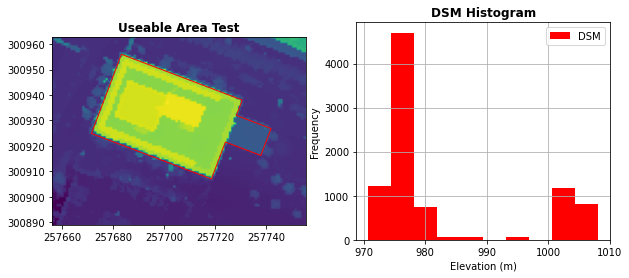

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(dsm, ax = ax1, title= 'Useable Area Test')
bldgs.plot(ax = ax1, facecolor='None', edgecolor='red')
show_hist(dsm, title='DSM Histogram', ax=ax2, label='DSM')
ax2.set_xlabel('Elevation (m)')
plt.show()

## Spatial statistics

In [43]:
# Assign raster values to a numpy array
dsm_arr = dsm.read(1)
affine = dsm.transform

# Calculate zonal statistics
stats = rasterstats.zonal_stats(bldgs, dsm_arr, affine=affine, 
    stats=['std', 'min', 'max', 'median', 'majority', 'minority', 'unique'],
    nodata=dsm.nodata)
majority = stats[0]['majority']
majority

1001.4691772460938

## Calculate useable area

In [44]:
def useable_area(x):
    """Calculates the area of the majority value (i.e. usable area)"""
    count_majority = ((x <= majority + 0.25) & (x >= majority - 0.25)).sum()
    return count_majority * affine[0] * -affine[4]

useable_area = rasterstats.zonal_stats(bldgs, dsm_arr, affine=affine,
    nodata=dsm.nodata, add_stats={'useable_area': useable_area})[0]['useable_area']
useable_area

682.2799257600554